In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx

sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import pickle
from sklearn.datasets import make_sparse_spd_matrix
from utils import calc_one_zero_error, calc_f1, calc_precision, calc_recall, calc_density, calc_roc_auc, calc_balanced_accuaray

In [2]:
# Function to calculate graph statistics

def append_stats(out_dict):
    out_dict['f1_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['f1_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['f1_n'][i].append(np.mean([calc_f1(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['f1_t'][i].append(np.mean([calc_f1(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    out_dict['prec_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['prec_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['prec_n'][i].append(np.mean([calc_precision(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['prec_t'][i].append(np.mean([calc_precision(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    out_dict['recall_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['recall_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['recall_n'][i].append(np.mean([calc_recall(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['recall_t'][i].append(np.mean([calc_recall(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    out_dict['bal_acc_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['bal_acc_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['bal_acc_n'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['bal_acc_t'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    out_dict['auc_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['auc_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['auc_n'][i].append(np.mean([calc_roc_auc(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['auc_t'][i].append(np.mean([calc_roc_auc(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))

    out_dict['Fro_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['Fro_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['Fro_n'][i].append(np.mean([scipy.linalg.norm(out_dict['prec'][k]-out_dict['theta_n'][i][j][k], ord = 'fro')/scipy.linalg.norm(out_dict['prec'][k], ord = 'fro') for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['Fro_t'][i].append(np.mean([scipy.linalg.norm(out_dict['prec'][k]-out_dict['theta_t'][i][j][k], ord = 'fro')/scipy.linalg.norm(out_dict['prec'][k], ord = 'fro') for k in range(len(out_dict['theta_n'][i][j]))]))



    return out_dict



In [3]:
# Function to calculate graph statistics

def append_stats_group(out_dict):
    out_dict['f1_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['f1_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['f1_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['f1_n'][i].append(np.mean([calc_f1(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['f1_t'][i].append(np.mean([calc_f1(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['f1_gt'][i].append(np.mean([calc_f1(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))

    out_dict['prec_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['prec_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['prec_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['prec_n'][i].append(np.mean([calc_precision(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['prec_t'][i].append(np.mean([calc_precision(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['prec_gt'][i].append(np.mean([calc_precision(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))

    out_dict['recall_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['recall_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['recall_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['recall_n'][i].append(np.mean([calc_recall(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['recall_t'][i].append(np.mean([calc_recall(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['recall_gt'][i].append(np.mean([calc_recall(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))

    out_dict['bal_acc_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['bal_acc_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['bal_acc_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['bal_acc_n'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['bal_acc_t'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['bal_acc_gt'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))

    out_dict['auc_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['auc_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['auc_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['auc_n'][i].append(np.mean([calc_roc_auc(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['auc_t'][i].append(np.mean([calc_roc_auc(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['auc_gt'][i].append(np.mean([calc_roc_auc(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))

    out_dict['Fro_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['Fro_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['Fro_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['Fro_n'][i].append(np.mean([scipy.linalg.norm(out_dict['prec'][k]-out_dict['theta_n'][i][j][k], ord = 'fro')/scipy.linalg.norm(out_dict['prec'][k], ord = 'fro') for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['Fro_t'][i].append(np.mean([scipy.linalg.norm(out_dict['prec'][k]-out_dict['theta_t'][i][j][k], ord = 'fro')/scipy.linalg.norm(out_dict['prec'][k], ord = 'fro') for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['Fro_gt'][i].append(np.mean([scipy.linalg.norm(out_dict['prec'][k]-out_dict['theta_gt'][i][j][k], ord = 'fro')/scipy.linalg.norm(out_dict['prec'][k], ord = 'fro') for k in range(len(out_dict['theta_gt'][i][j]))]))



    return out_dict



In [4]:
def append_stats_skew(out_dict):
    out_dict['f1_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['f1_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['f1_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    out_dict['f1_st'] = {i: [] for i in range(len(out_dict['theta_st']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['f1_n'][i].append(np.mean([calc_f1(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['f1_t'][i].append(np.mean([calc_f1(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['f1_gt'][i].append(np.mean([calc_f1(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))
            out_dict['f1_st'][i].append(np.mean([calc_f1(out_dict['prec'][k], out_dict['theta_st'][i][j][k]) for k in range(len(out_dict['theta_st'][i][j]))]))

    out_dict['prec_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['prec_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['prec_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    out_dict['prec_st'] = {i: [] for i in range(len(out_dict['theta_st']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['prec_n'][i].append(np.mean([calc_precision(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['prec_t'][i].append(np.mean([calc_precision(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['prec_gt'][i].append(np.mean([calc_precision(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))
            out_dict['prec_st'][i].append(np.mean([calc_precision(out_dict['prec'][k], out_dict['theta_st'][i][j][k]) for k in range(len(out_dict['theta_st'][i][j]))]))

    out_dict['recall_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['recall_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['recall_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    out_dict['recall_st'] = {i: [] for i in range(len(out_dict['theta_st']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['recall_n'][i].append(np.mean([calc_recall(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['recall_t'][i].append(np.mean([calc_recall(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['recall_gt'][i].append(np.mean([calc_recall(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))
            out_dict['recall_st'][i].append(np.mean([calc_recall(out_dict['prec'][k], out_dict['theta_st'][i][j][k]) for k in range(len(out_dict['theta_st'][i][j]))]))

    out_dict['bal_acc_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['bal_acc_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['bal_acc_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    out_dict['bal_acc_st'] = {i: [] for i in range(len(out_dict['theta_st']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['bal_acc_n'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['bal_acc_t'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['bal_acc_gt'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))
            out_dict['bal_acc_st'][i].append(np.mean([calc_balanced_accuaray(out_dict['prec'][k], out_dict['theta_st'][i][j][k]) for k in range(len(out_dict['theta_st'][i][j]))]))

    out_dict['auc_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['auc_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['auc_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    out_dict['auc_st'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['auc_n'][i].append(np.mean([calc_roc_auc(out_dict['prec'][k], out_dict['theta_n'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['auc_t'][i].append(np.mean([calc_roc_auc(out_dict['prec'][k], out_dict['theta_t'][i][j][k]) for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['auc_gt'][i].append(np.mean([calc_roc_auc(out_dict['prec'][k], out_dict['theta_gt'][i][j][k]) for k in range(len(out_dict['theta_gt'][i][j]))]))
            out_dict['auc_st'][i].append(np.mean([calc_roc_auc(out_dict['prec'][k], out_dict['theta_st'][i][j][k]) for k in range(len(out_dict['theta_st'][i][j]))]))

    out_dict['Fro_n'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['Fro_t'] = {i: [] for i in range(len(out_dict['theta_n']))}
    out_dict['Fro_gt'] = {i: [] for i in range(len(out_dict['theta_gt']))}
    out_dict['Fro_st'] = {i: [] for i in range(len(out_dict['theta_st']))}
    for i in range(len(out_dict['theta_n'])):
        for j in range(len(out_dict['theta_n'][i])):
            out_dict['Fro_n'][i].append(np.mean([scipy.linalg.norm(out_dict['prec'][k]-out_dict['theta_n'][i][j][k], ord = 'fro')/scipy.linalg.norm(out_dict['prec'][k], ord = 'fro') for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['Fro_t'][i].append(np.mean([scipy.linalg.norm(out_dict['prec'][k]-out_dict['theta_t'][i][j][k], ord = 'fro')/scipy.linalg.norm(out_dict['prec'][k], ord = 'fro') for k in range(len(out_dict['theta_n'][i][j]))]))
            out_dict['Fro_gt'][i].append(np.mean([scipy.linalg.norm(out_dict['prec'][k]-out_dict['theta_gt'][i][j][k], ord = 'fro')/scipy.linalg.norm(out_dict['prec'][k], ord = 'fro') for k in range(len(out_dict['theta_gt'][i][j]))]))
            out_dict['Fro_st'][i].append(np.mean([scipy.linalg.norm(out_dict['prec'][k]-out_dict['theta_st'][i][j][k], ord = 'fro')/scipy.linalg.norm(out_dict['prec'][k], ord = 'fro') for k in range(len(out_dict['theta_st'][i][j]))]))



    return out_dict


# Gaussian data

Read Data

In [8]:
with open(f'../data/gauss_group_skew/gaussian_groupt_gaussian_search_d_20_n_300_s_0.25_erdos.pkl', 'rb') as handle:
    gauss_dict = pickle.load(handle)

gauss_dict['prec'] = [gauss_dict['A1']] * 3 + [gauss_dict['A2']] * 3



Calculate statistics

In [9]:
gauss_dict = append_stats(gauss_dict)


plot

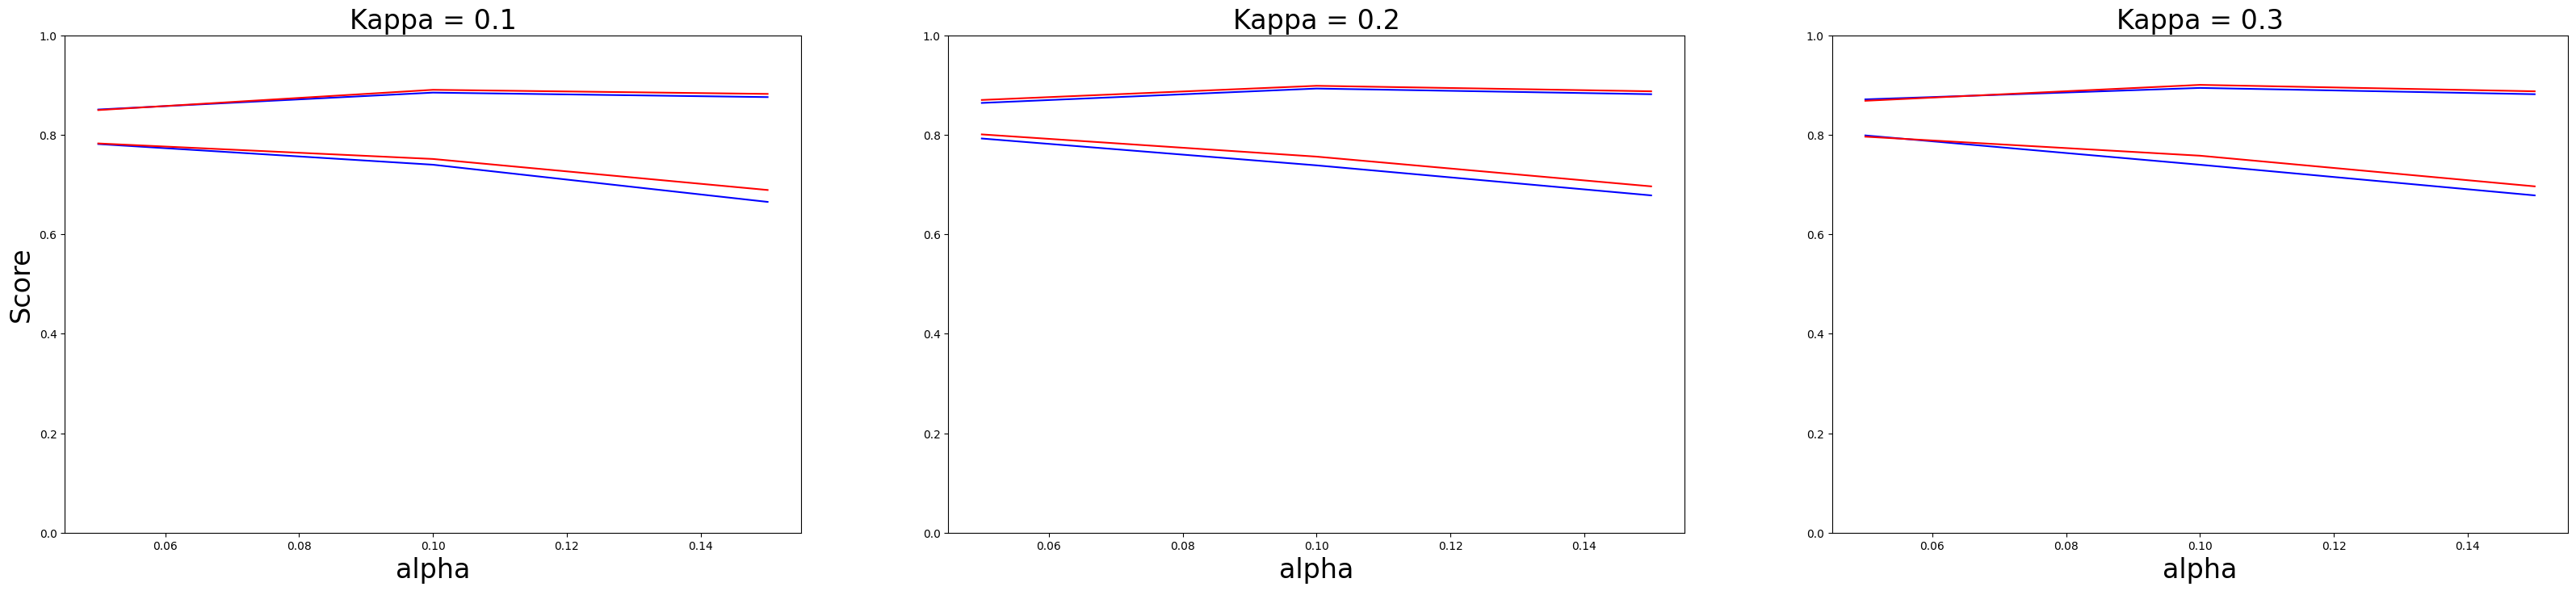

In [10]:
fig, ax = plt.subplots(1,3, figsize = (40,8))
for i,k_idx in enumerate([0,1,2]):

    ax[i].plot(gauss_dict['alpha'],gauss_dict['f1_t'][k_idx], label = 'T f1', color = 'blue')
    ax[i].plot(gauss_dict['alpha'],gauss_dict['f1_n'][k_idx], label = 'Normal f1', color = 'red')

    # ax[i].plot(out_dict['alpha'],out_dict['prec_t'][k_idx], label = 'T precision', color = 'blue', linestyle = 'dashed')
    # ax[i].plot(out_dict['alpha'],out_dict['prec_n'][k_idx], label = 'Normal, precision', color = 'red', linestyle = 'dashed')

    # ax[i].plot(out_dict['alpha'],out_dict['recall_t'][k_idx], label = 'T recall', color = 'blue')
    # ax[i].plot(out_dict['alpha'],out_dict['recall_n'][k_idx], label = 'Normal recall', color = 'red')

    #ax.plot(out_dict['alpha'],out_dict['bal_acc_t'][k_idx], label = 'T bal. acc.', color = 'blue', linestyle = (0, (3, 5, 1, 5, 1, 5)))
    #ax.plot(out_dict['alpha'],out_dict['bal_acc_n'][k_idx], label = 'Normal bal. acc.', color = 'red', linestyle = (0, (3, 5, 1, 5, 1, 5)))

    ax[i].plot(gauss_dict['alpha'],gauss_dict['auc_t'][k_idx], label = 'T auc', color = 'blue')
    ax[i].plot(gauss_dict['alpha'],gauss_dict['auc_n'][k_idx], label = 'Normal auc', color = 'red')

    ax[i].set_xlabel("alpha", fontdict= {'fontsize':24})
    if i == 0:
        ax[i].set_ylabel("Score", fontdict= {'fontsize':24})
    ax[i].set_title(f"Kappa = {np.round(gauss_dict['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
    ax[i].set_ylim([0,1])

    if i == 4-1:
        legend  = ax[i].legend(title = "",fontsize = 18)
        legend.get_title().set_fontsize('18')

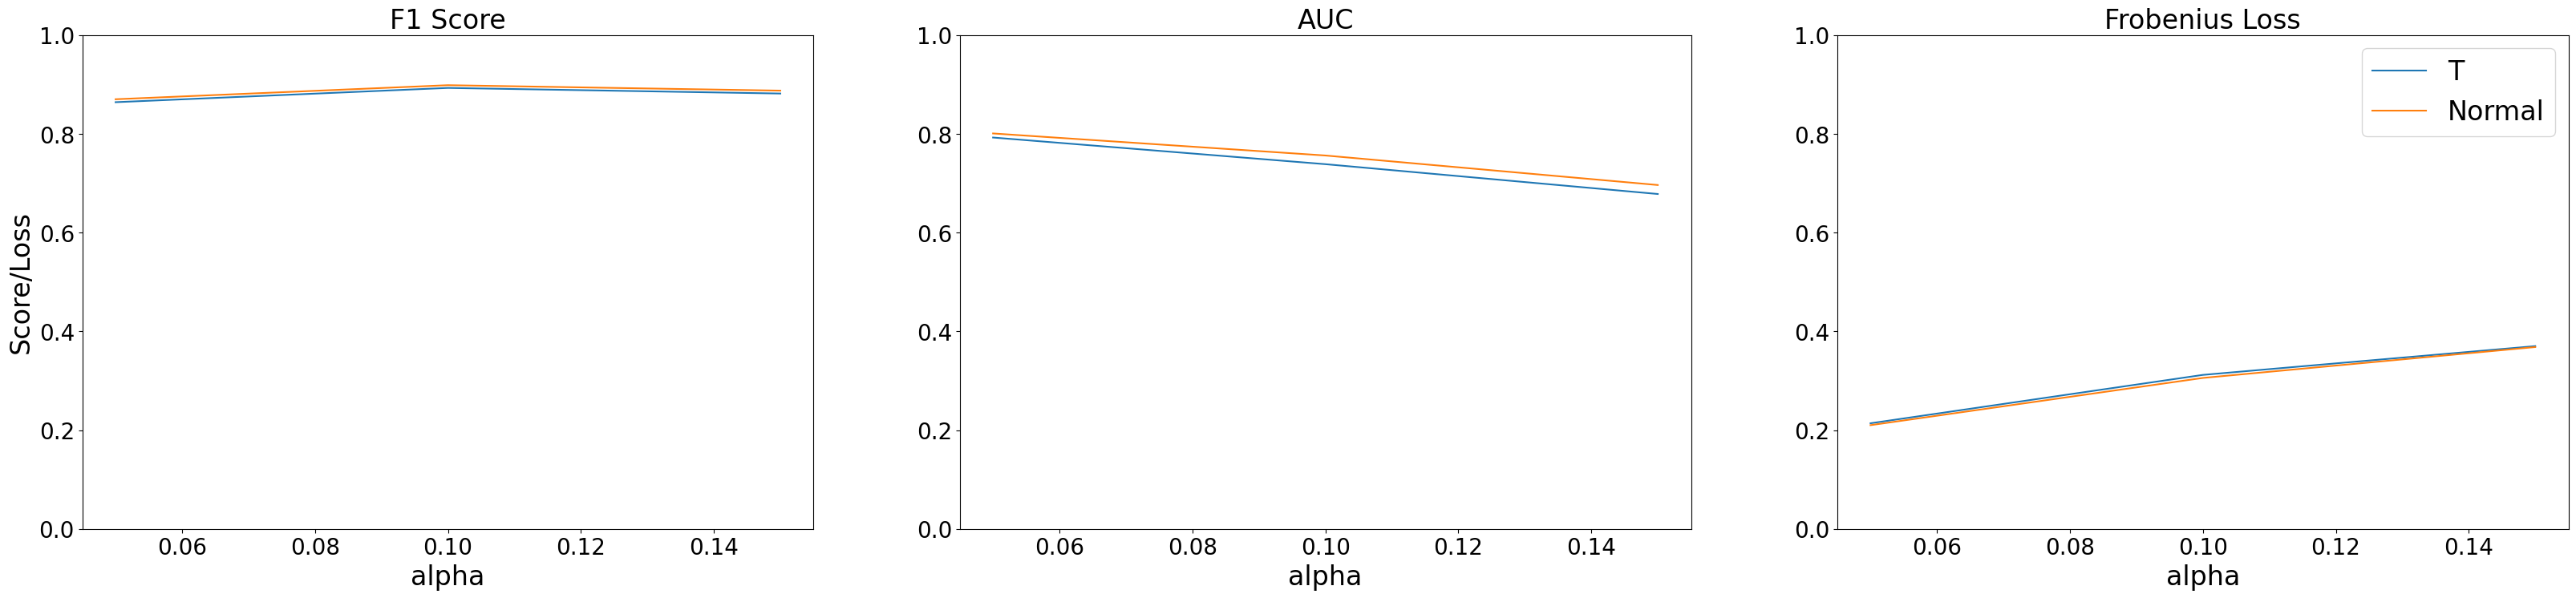

In [30]:
fig, ax = plt.subplots(1,3, figsize = (40,8))
for i,k_idx in enumerate([1]):

    ax[0].plot(gauss_dict['alpha'],gauss_dict['f1_t'][k_idx], label = 'T')
    ax[0].plot(gauss_dict['alpha'],gauss_dict['f1_n'][k_idx], label = 'Normal')
    ax[0].set_title(f"F1 Score", fontdict = {'fontsize':24})
    ax[0].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[0].set_ylim([0,1])
    ax[0].set_ylabel("Score/Loss", fontdict= {'fontsize':24})
    ax[0].tick_params(axis='both', which='major', labelsize=20)

    ax[1].plot(gauss_dict['alpha'],gauss_dict['auc_t'][k_idx], label = 'T')
    ax[1].plot(gauss_dict['alpha'],gauss_dict['auc_n'][k_idx], label = 'Normal')
    ax[1].set_title(f"AUC", fontdict = {'fontsize':24})
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[1].tick_params(axis='both', which='major', labelsize=20)


    ax[2].plot(gauss_dict['alpha'],gauss_dict['Fro_t'][k_idx], label = 'T')
    ax[2].plot(gauss_dict['alpha'],gauss_dict['Fro_n'][k_idx], label = 'Normal')
    ax[2].set_title(f"Frobenius Loss", fontdict = {'fontsize':24})
    ax[2].set_ylim([0,1])
    ax[2].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[2].tick_params(axis='both', which='major', labelsize=20)

    legend  = ax[2].legend(title = "",fontsize = 24)
    legend.get_title().set_fontsize('24')

# T data

In [31]:
with open(f'../data/gauss_group_skew/t_search_d_20_n_300_s_0.25_erdos.pkl', 'rb') as handle:
    t_dict = pickle.load(handle)

t_dict = append_stats_group(t_dict)



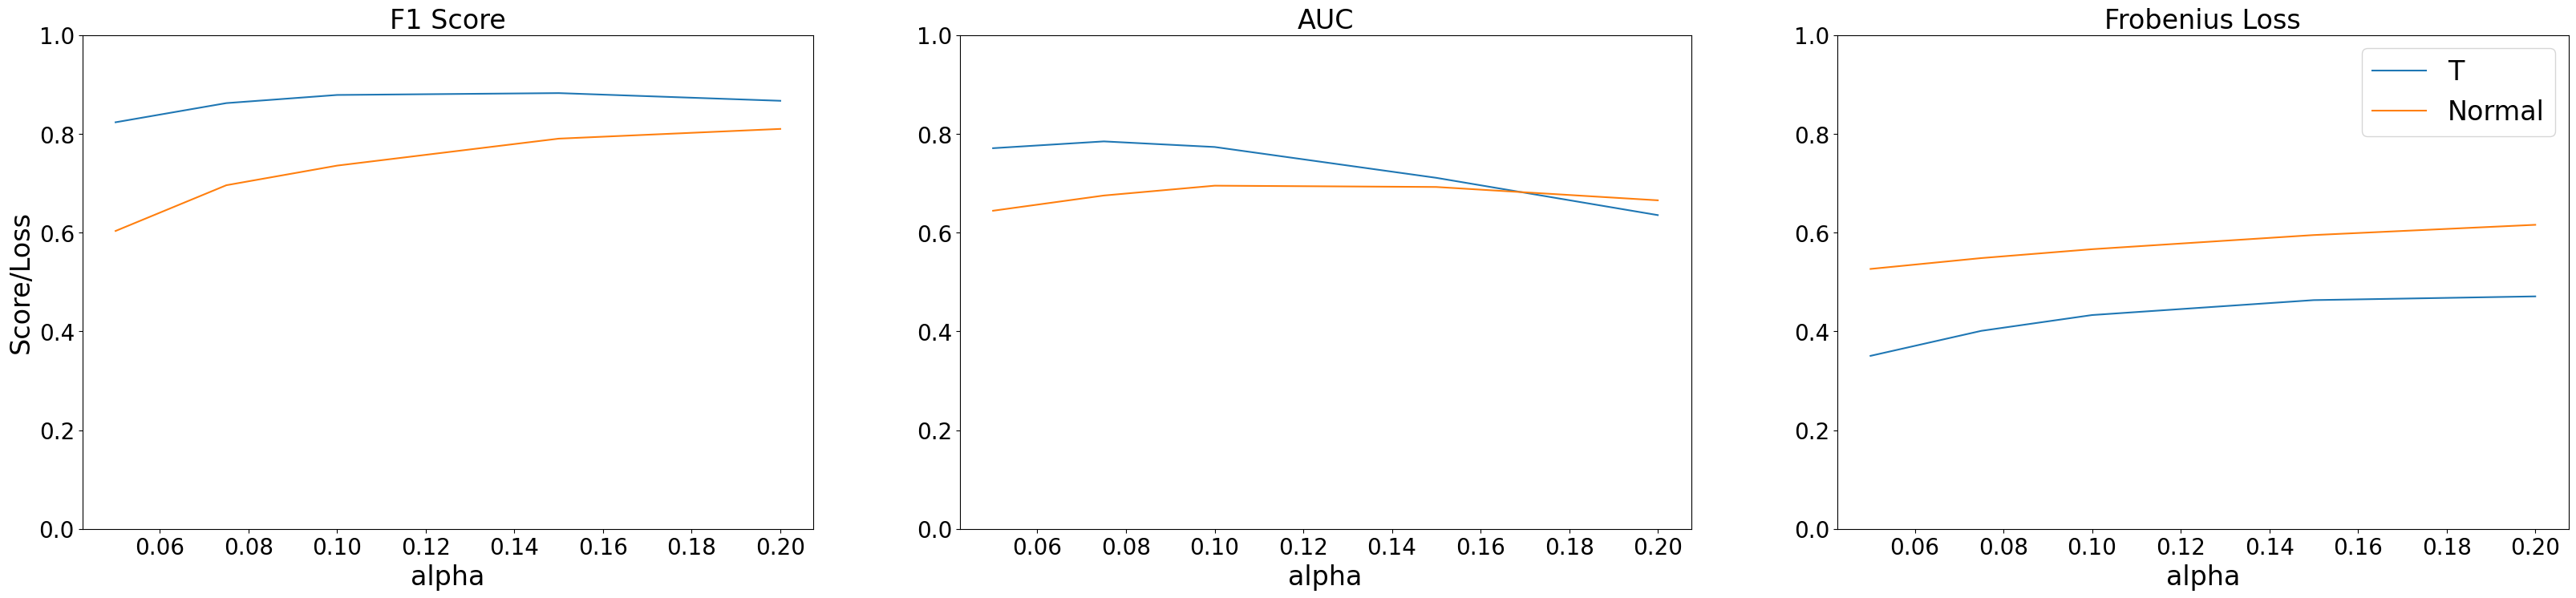

In [32]:
fig, ax = plt.subplots(1,3, figsize = (40,8))
for i,k_idx in enumerate([1]):

    ax[0].plot(t_dict['alpha'],t_dict['f1_t'][k_idx], label = 'T')
    ax[0].plot(t_dict['alpha'],t_dict['f1_n'][k_idx], label = 'Normal')
    ax[0].set_title(f"F1 Score", fontdict = {'fontsize':24})
    ax[0].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[0].set_ylim([0,1])
    ax[0].set_ylabel("Score/Loss", fontdict= {'fontsize':24})
    ax[0].tick_params(axis='both', which='major', labelsize=20)

    ax[1].plot(t_dict['alpha'],t_dict['auc_t'][k_idx], label = 'T')
    ax[1].plot(t_dict['alpha'],t_dict['auc_n'][k_idx], label = 'Normal')
    ax[1].set_title(f"AUC", fontdict = {'fontsize':24})
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[1].tick_params(axis='both', which='major', labelsize=20)


    ax[2].plot(t_dict['alpha'],t_dict['Fro_t'][k_idx], label = 'T')
    ax[2].plot(t_dict['alpha'],t_dict['Fro_n'][k_idx], label = 'Normal')
    ax[2].set_title(f"Frobenius Loss", fontdict = {'fontsize':24})
    ax[2].set_ylim([0,1])
    ax[2].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[2].tick_params(axis='both', which='major', labelsize=20)

    legend  = ax[2].legend(title = "",fontsize = 24)
    legend.get_title().set_fontsize('24')

# Group-T data


In [33]:
with open(f'../data/gauss_group_skew/group_search_d_20_n_300_s_0.35_nrquad_10_erdos.pkl', 'rb') as handle:
    group_dict = pickle.load(handle)

group_dict = append_stats_group(group_dict)


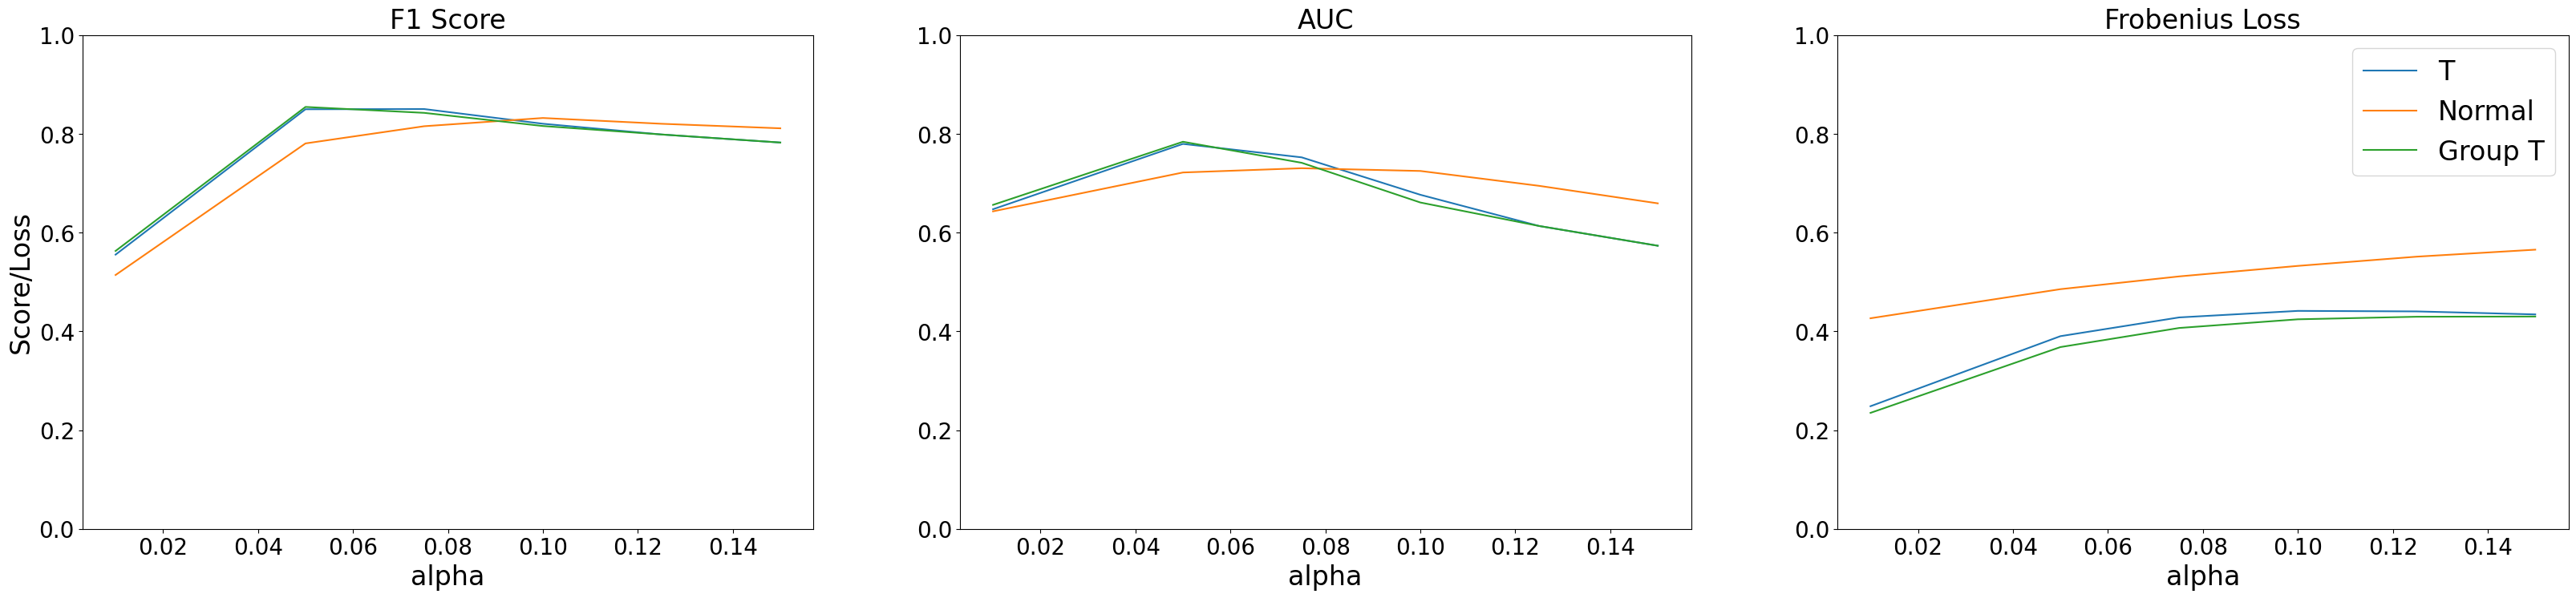

In [35]:
fig, ax = plt.subplots(1,3, figsize = (40,8))
for i,k_idx in enumerate([1]):

    ax[0].plot(group_dict['alpha'],group_dict['f1_t'][k_idx], label = 'T')
    ax[0].plot(group_dict['alpha'],group_dict['f1_n'][k_idx], label = 'Normal')
    ax[0].plot(group_dict['alpha'],group_dict['f1_gt'][k_idx], label = 'Group T')
    ax[0].set_title(f"F1 Score", fontdict = {'fontsize':24})
    ax[0].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[0].set_ylim([0,1])
    ax[0].set_ylabel("Score/Loss", fontdict= {'fontsize':24})
    ax[0].tick_params(axis='both', which='major', labelsize=20)

    ax[1].plot(group_dict['alpha'],group_dict['auc_t'][k_idx], label = 'T')
    ax[1].plot(group_dict['alpha'],group_dict['auc_n'][k_idx], label = 'Normal')
    ax[1].plot(group_dict['alpha'],group_dict['auc_gt'][k_idx], label = 'Group T')
    ax[1].set_title(f"AUC", fontdict = {'fontsize':24})
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[1].tick_params(axis='both', which='major', labelsize=20)


    ax[2].plot(group_dict['alpha'],group_dict['Fro_t'][k_idx], label = 'T')
    ax[2].plot(group_dict['alpha'],group_dict['Fro_n'][k_idx], label = 'Normal')
    ax[2].plot(group_dict['alpha'],group_dict['Fro_gt'][k_idx], label = 'Group T')
    ax[2].set_title(f"Frobenius Loss", fontdict = {'fontsize':24})
    ax[2].set_ylim([0,1])
    ax[2].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[2].tick_params(axis='both', which='major', labelsize=20)


    legend  = ax[2].legend(title = "",fontsize = 24)
    legend.get_title().set_fontsize('24')

In [24]:
group_dict['f1_t'][2]

[0.4556962025316456,
 0.8284518828451883,
 0.8346456692913385,
 0.8161764705882354,
 0.7972027972027972,
 0.7781569965870307]

In [23]:
group_dict['f1_gt'][2]

[0.3943016412958733,
 0.8370671589811637,
 0.8341806814952594,
 0.8079239340474157,
 0.7959064477156056,
 0.7786011501238955]

# Skew-T data


In [5]:
with open(f'../data/gauss_group_skew/skew_search_d_20_n_300_s_0.35_nrquad_10_erdos_hradar_hk.pkl', 'rb') as handle:
    skew_test = pickle.load(handle)

skew_test = append_stats_skew(skew_test)


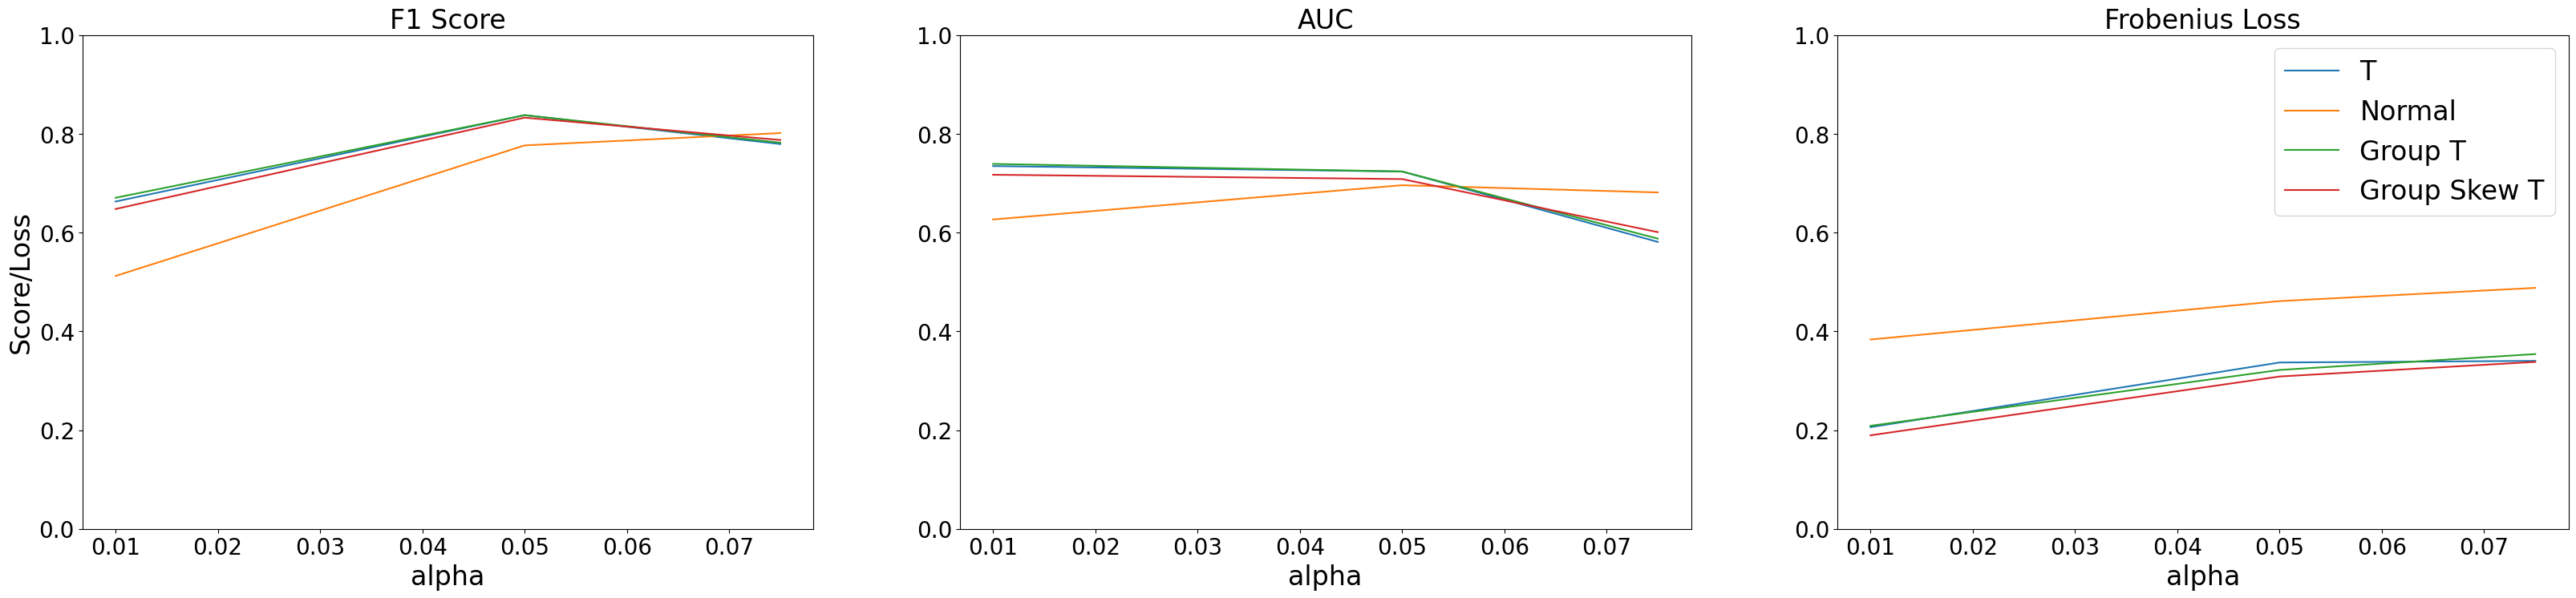

In [6]:
fig, ax = plt.subplots(1,3, figsize = (40,8))
for i,k_idx in enumerate([0]):

    ax[0].plot(skew_test['alpha'],skew_test['f1_t'][k_idx], label = 'T')
    ax[0].plot(skew_test['alpha'],skew_test['f1_n'][k_idx], label = 'Normal')
    ax[0].plot(skew_test['alpha'],skew_test['f1_gt'][k_idx], label = 'Group T')
    ax[0].plot(skew_test['alpha'],skew_test['f1_st'][k_idx], label = 'Group Skew T')
    ax[0].set_title(f"F1 Score", fontdict = {'fontsize':24})
    ax[0].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[0].set_ylim([0,1])
    ax[0].set_ylabel("Score/Loss", fontdict= {'fontsize':24})
    ax[0].tick_params(axis='both', which='major', labelsize=20)

    ax[1].plot(skew_test['alpha'],skew_test['auc_t'][k_idx], label = 'T')
    ax[1].plot(skew_test['alpha'],skew_test['auc_n'][k_idx], label = 'Normal')
    ax[1].plot(skew_test['alpha'],skew_test['auc_gt'][k_idx], label = 'Group T')
    ax[1].plot(skew_test['alpha'],skew_test['auc_st'][k_idx], label = 'Group Skew T')
    ax[1].set_title(f"AUC", fontdict = {'fontsize':24})
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[1].tick_params(axis='both', which='major', labelsize=20)


    ax[2].plot(skew_test['alpha'],skew_test['Fro_t'][k_idx], label = 'T')
    ax[2].plot(skew_test['alpha'],skew_test['Fro_n'][k_idx], label = 'Normal')
    ax[2].plot(skew_test['alpha'],skew_test['Fro_gt'][k_idx], label = 'Group T')
    ax[2].plot(skew_test['alpha'],skew_test['Fro_st'][k_idx], label = 'Group Skew T')
    ax[2].set_title(f"Frobenius Loss", fontdict = {'fontsize':24})
    ax[2].set_ylim([0,1])
    ax[2].set_xlabel("alpha", fontdict= {'fontsize':24})
    ax[2].tick_params(axis='both', which='major', labelsize=20)


    legend  = ax[2].legend(title = "",fontsize = 24)
    legend.get_title().set_fontsize('24')